In [1]:
!pip install --upgrade pandas pyarrow
!pip install --upgrade matplotlib seaborn missingno numexpr bottleneck



[notice] A new release of pip is available: 25.0 -> 26.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.0 -> 26.0
[notice] To update, run: pip install --upgrade pip


In [2]:
import re
import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt  
import seaborn as sns 
import missingno as msno 
import json
import os 
from IPython.display import display, HTML




np.random.seed(42) 


In [ ]:
UTSG_DATA = pd.read_csv('DATA/UTSG_ML_data_food.csv')
UTM_DATA = pd.read_csv('DATA/UTM_ML_data_food.csv')
UTSG_DATA.insert(0, "campus", 'UTSG')
UTM_DATA.insert(0, "campus", 'UTM')
from sklearn.model_selection import train_test_split

# frames = [UTSG_DATA,UTM_DATA]
# data = pd.concat(frames)


In [4]:

def standardize_response_col_names(dataset):
    title = 'Answer the following questions about the food item:'
    new_cols = []
    cols_to_drop = []
    current_food = None
    
    for i, col in enumerate(dataset.columns):
        if title in str(col):
            current_food = col.split(':')[2].strip()
            cols_to_drop.append(col)  
        elif current_food and ':' in str(col):
            question = col.split(':', 1)[1].strip()
            new_cols.append(f"{current_food} {question}")
        else:
            new_cols.append(col)
    
    dataset = dataset.drop(columns=cols_to_drop)
    dataset.columns = new_cols
    
    return dataset

def clean_cols(dataset):
    cols_to_drop = [col for col in dataset.columns if '0.' in str(col)] + ['1.0', '0']
    data_dropped = dataset.drop(columns=cols_to_drop, errors='ignore')
    dataset = standardize_response_col_names(data_dropped)
    return dataset

def reshape_food_data(data_set):
    """
    Reshape dataframe from wide to long format.
    Each row is split into 3 rows (one for Pizza, Shawarma, and Sushi).
    """
    base_cols = [
        'From a scale 1 to 5, how complex is it to make this food? (Where 1 is the most simple, and 5 is the most complex)',
        'How many ingredients would you expect this food item to contain?',
        'In what setting would you expect this food to be served? Please check all that apply',
        'How much would you expect to pay for one serving of this food item?',
        'What movie do you think of when thinking of this food item?',
        'What drink would you pair with this food item?',
        'When you think about this food item, who does it remind you of?',
        'How much hot sauce would you add to this food item?'
    ]
    
    new_rows = []
    
    for idx, row in data_set.iterrows():
        pizza_data = {'ID': row['ID'], 'Food': 'Pizza'}
        for col in base_cols:
            pizza_data[col] = row[f'Pizza {col}']
        pizza_data['n correct'] = row['n correct']
        pizza_data['n incorrect'] = row['n incorrect']
        pizza_data['score'] = row['score']
        new_rows.append(pizza_data)
        
        shawarma_data = {'ID': row['ID'], 'Food': 'Shawarma'}
        for col in base_cols:
            shawarma_data[col] = row[f'Shawarma {col}']
        shawarma_data['n correct'] = row['n correct']
        shawarma_data['n incorrect'] = row['n incorrect']
        shawarma_data['score'] = row['score']
        new_rows.append(shawarma_data)
        
        sushi_data = {'ID': row['ID'], 'Food': 'Sushi'}
        for col in base_cols:
            sushi_data[col] = row[f'Sushi {col}']
        sushi_data['n correct'] = row['n correct']
        sushi_data['n incorrect'] = row['n incorrect']
        sushi_data['score'] = row['score']
        new_rows.append(sushi_data)
    
    data_set_split = pd.DataFrame(new_rows)
    
    return data_set_split


def parse_ingredient_count(value):

    # Deal with missing value 
    if pd.isna(value):
        return None, None, None
    
    value_str = str(value).strip()
    original = value_str
    
    # Word to number mapping
    word_to_num = {
        'zero': 0, 'one': 1, 'two': 2, 'three': 3, 'four': 4, 'five': 5,
        'six': 6, 'seven': 7, 'eight': 8, 'nine': 9, 'ten': 10,
        'eleven': 11, 'twelve': 12, 'thirteen': 13, 'fourteen': 14, 'fifteen': 15,
        'sixteen': 16, 'seventeen': 17, 'eighteen': 18, 'nineteen': 19, 'twenty': 20
    }
    
    value_lower = value_str.lower()
    
    # remove unused symbol
    value_cleaned = value_str.replace('~', '').strip()
    
    # Best case: First just attempt to get the lone value
    try:
        count = float(value_str)
        return count, count, count
    except:
        pass

    # Harder cases
    # Find "to" ranges like e.g. "3 to 7"
    to_range_match = re.search(r'(\d+)\s+to\s+(\d+)', value_cleaned)
    if to_range_match:
        num1 = float(to_range_match.group(1)) #lower bound
        num2 = float(to_range_match.group(2)) #upper bound
        min_count = min(num1, num2)
        max_count = max(num1, num2)
        avg_count = (min_count + max_count) / 2
        return min_count, max_count, avg_count
    
    # Find ranges with dash e.g. "6-8"
    dash_range_match = re.search(r'(\d+)\s*-\s*(\d+)', value_cleaned)
    if dash_range_match:
        num1 = float(dash_range_match.group(1)) #lower bound
        num2 = float(dash_range_match.group(2)) #upper bound
        min_count = min(num1, num2)
        max_count = max(num1, num2)
        avg_count = (min_count + max_count) / 2
        return min_count, max_count, avg_count
    
    # Find "at least X" pattern
    at_least_match = re.search(r'at least\s+(\d+)', value_lower)
    if at_least_match:
        count = float(at_least_match.group(1))
        return count, count, count
    # Find "about/around X" pattern (treat as exact)
    about_match = re.search(r'(?:about|around|approximately)\s+(\d+)', value_lower)
    if about_match:
        count = float(about_match.group(1))
        return count, count, count
    
    # Find "X:<ingredient list>" pattern
    colon_match = re.search(r'^(\d+)\s*:', value_cleaned)
    if colon_match:
        count = float(colon_match.group(1))
        return count, count, count
    
    # Check for word numbers like "about three"
    for word, num in word_to_num.items():
        if word in value_lower:
            return float(num), float(num), float(num)
    
    # Count bullet point lists (markdown lists with * or -)
    bullet_matches = re.findall(r'^\s*[\*\-•]\s+.+', value_str, re.MULTILINE)
    if len(bullet_matches) > 0:
        count = float(len(bullet_matches))
        return count, count, count
    
    # Edge cases surrounded by junk text
    lines = value_str.split('\n')
    cleaned_lines = [line.strip() for line in lines if line.strip()]
    
    # Filter out header/intro lines
    ingredient_lines = []
    skip_patterns = [
        r'^i would expect',
        r'^it (would|should|might|could) (contain|have|include)',
        r'^\d+\s*:?\s*$',  # Just a number
    ]
    
    for line in cleaned_lines:
        line_lower = line.lower()
        if any(re.match(pattern, line_lower) for pattern in skip_patterns):
            continue
        ingredient_lines.append(line)
    
    # If we have multiple ingredient lines, count them
    if len(ingredient_lines) >= 2:
        count = float(len(ingredient_lines))
        return count, count, count
    
    # If we have exactly 1 ingredient line and there was a newline in original
    if len(ingredient_lines) == 1 and '\n' in value_str:
        return 1.0, 1.0, 1.0
    
    # Count commas in ingredient list
    if ',' in value_str:
        items = [item.strip() for item in value_str.split(',') if item.strip()]
        ingredient_items = [item for item in items if len(item) >= 2]
        if len(ingredient_items) > 1:
            count = float(len(ingredient_items))
            return count, count, count
    # Single word/phrase ingredient
    if '\n' not in value_str and len(value_str.split()) <= 4 and not any(char.isdigit() for char in value_str):
        return 1.0, 1.0, 1.0
    
    # Extract any number found in the string as last resort
    numbers = re.findall(r'\d+', value_str)
    if numbers:
        count = float(numbers[0])
        return count, count, count,
    
    return None, None, None


def apply_ingredient_parsing(df):
    column_name = 'How many ingredients would you expect this food item to contain?'
    results = df[column_name].apply(parse_ingredient_count)
    df[f'{column_name} (min)'] = results.apply(lambda x: x[0])
    df[f'{column_name} (max)'] = results.apply(lambda x: x[1])
    df['ingredient_count'] = results.apply(lambda x: x[2])

    
    return df



In [5]:
# canonicalizing movies 


def clean_text_for_matching(text):
    """Clean text for matching"""
    if pd.isna(text):
        return ''
    
    text = str(text).lower().strip()
    
    # Normalize all apostrophes to straight apostrophe FIRST
    text = text.replace(''', '\'').replace(''', '\'')
    
    # Remove quotation marks (both single and double) but NOT apostrophes
    text = text.replace('"', '').replace('"', '').replace('"', '')
    
    # Remove special whitespace characters
    text = re.sub(r'[\xa0\u200b\u200c\u200d\ufeff]', '', text)
    text = re.sub(r'\s+', ' ', text)
    
    # Remove common filler words at start
    text = re.sub(r'^(i think of |thinking of |reminds me of |the movie |movie |film )', '', text)
    
    # Remove punctuation at the end
    text = re.sub(r'[.,;!?]+$', '', text)
    
    return text.strip()


def map_to_canonical_movie(text, movie_mapping):
    """
    Map input text to a canonical movie title.
    """
    if pd.isna(text):
        return np.nan
    
    cleaned_text = clean_text_for_matching(text)
    
    if not cleaned_text:
        return np.nan
 
    # Try to match against canonical titles and their variations
    best_match = None
    longest_match_len = 0
    
    for canonical_title, variations in movie_mapping.items():
        for variation in variations:
            if len(variation) <= 2:
                pattern = r'\b' + re.escape(variation) + r'\b'
                if re.search(pattern, cleaned_text):
                    if len(variation) > longest_match_len:
                        longest_match_len = len(variation)
                        best_match = canonical_title
            else:
                if variation in cleaned_text:
                    if len(variation) > longest_match_len:
                        longest_match_len = len(variation)
                        best_match = canonical_title
    
    return best_match if best_match else np.nan


def apply_movie_mapping(df, column_name, output_column='movie_canonical', mapping_file='movie_mapping.json'):

    # Load movie mapping from JSON
    with open(mapping_file, 'r', encoding='utf-8') as f:
        movie_mapping = json.load(f)
    
    # Apply mapping
    df[output_column] = df[column_name].apply(
        lambda x: map_to_canonical_movie(x, movie_mapping)
    )
    

    
    
    return df


def create_movie_onehot_columns(df, movie_column='movie_canonical', prefix='movie'):

    # Get one-hot encoding exclude NaN from being a col
    one_hot = pd.get_dummies(df[movie_column], prefix=prefix, dummy_na=False)
    
    # Convert boolean to int 1/0 
    one_hot = one_hot.astype(int)
    
    # add one hot vectors
    df = pd.concat([df, one_hot], axis=1)
    

    
    return df


In [ ]:

def extract_price_smart(value):
    """Extract price intelligently, prioritizing numbers near $ or price keywords"""
    if pd.isna(value):
        return pd.Series({'min_price': None, 'max_price': None, 'avg_price': None})
    
    value_str = str(value).strip()
    
    # Look for numbers adjacent to $ symbol
    dollar_pattern = r'\$\s*(\d+\.?\d*)\s*-?\s*\$?\s*(\d+\.?\d*)?'
    dollar_matches = re.findall(dollar_pattern, value_str)
    
    if dollar_matches:
        # Found $ sign with numbers
        nums = [float(n) for match in dollar_matches for n in match if n]
        if len(nums) == 1:
            return pd.Series({'min_price': nums[0], 'max_price': nums[0], 'avg_price': nums[0]})
        else:
            min_p = min(nums[0], nums[1])
            max_p = max(nums[0], nums[1])
            return pd.Series({'min_price': min_p, 'max_price': max_p, 'avg_price': (min_p + max_p) / 2})
    
    # Look for price keywords followed by numbers
    value_lower = value_str.lower()
    price_keywords = ['price', 'cost', 'costs', 'dollars', 'dollar', '~', 'around', 'approximately']
    
    for keyword in price_keywords:
        if keyword in value_lower:
            # Extract numbers after the keyword
            keyword_pos = value_lower.find(keyword)
            after_keyword = value_str[keyword_pos:]
            numbers = re.findall(r'\d+\.?\d*', after_keyword)
            numbers = [float(n) for n in numbers if float(n) < 1000]
            
            if numbers:
                if len(numbers) == 1:
                    return pd.Series({'min_price': numbers[0], 'max_price': numbers[0], 'avg_price': numbers[0]})
                else:
                    min_p = min(numbers[0], numbers[1])
                    max_p = max(numbers[0], numbers[1])
                    return pd.Series({'min_price': min_p, 'max_price': max_p, 'avg_price': (min_p + max_p) / 2})
    
    # extract all numbers and filter by reasonable price range
    all_numbers = re.findall(r'\d+\.?\d*', value_str)
    all_numbers = [float(n) for n in all_numbers]
    
    # Filter to reasonable price range (between 0.5 and 500)
    price_numbers = [n for n in all_numbers if 0.5 <= n <= 500]
    
    if not price_numbers:
        # If no reasonable prices, return all numbers
        price_numbers = all_numbers
    
    if len(price_numbers) == 0:
        return pd.Series({'min_price': None, 'max_price': None, 'avg_price': None})
    elif len(price_numbers) == 1:
        return pd.Series({'min_price': price_numbers[0], 'max_price': price_numbers[0], 'avg_price': price_numbers[0]})
    else:
        # Take last one or two numbers (heuristic usually price comes at the end) 
        relevant = price_numbers[-2:] if len(price_numbers) >= 2 else price_numbers
        min_p = min(relevant)
        max_p = max(relevant)
        return pd.Series({'min_price': min_p, 'max_price': max_p, 'avg_price': (min_p + max_p) / 2})



In [ ]:
utsg_data_cleaned = clean_cols(UTSG_DATA) 
utm_data_cleaned = clean_cols(UTM_DATA) 

frames = [utsg_data_cleaned,utm_data_cleaned]
data = pd.concat(frames)
data = data.drop(data.columns[0:9], axis=1) 
data.insert(0, 'ID', range(len(data)))
data.columns


Index(['ID',
       'Pizza From a scale 1 to 5, how complex is it to make this food? (Where 1 is the most simple, and 5 is the most complex)',
       'Pizza How many ingredients would you expect this food item to contain?',
       'Pizza In what setting would you expect this food to be served? Please check all that apply',
       'Pizza How much would you expect to pay for one serving of this food item?',
       'Pizza What movie do you think of when thinking of this food item?',
       'Pizza What drink would you pair with this food item?',
       'Pizza When you think about this food item, who does it remind you of?',
       'Pizza How much hot sauce would you add to this food item?',
       'Shawarma From a scale 1 to 5, how complex is it to make this food? (Where 1 is the most simple, and 5 is the most complex)',
       'Shawarma How many ingredients would you expect this food item to contain?',
       'Shawarma In what setting would you expect this food to be served? Please check 

In [8]:
data_reshaped = reshape_food_data(data)

display(HTML(f"""
<div style="max-height:400px; overflow-y:auto;">
{data_reshaped.to_html(index=False)}
</div>
"""))

ID,Food,"From a scale 1 to 5, how complex is it to make this food? (Where 1 is the most simple, and 5 is the most complex)",How many ingredients would you expect this food item to contain?,In what setting would you expect this food to be served? Please check all that apply,How much would you expect to pay for one serving of this food item?,What movie do you think of when thinking of this food item?,What drink would you pair with this food item?,"When you think about this food item, who does it remind you of?",How much hot sauce would you add to this food item?,n correct,n incorrect,score
0,Pizza,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15,12,1.0
0,Shawarma,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15,12,1.0
0,Sushi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15,12,1.0
1,Pizza,3.0,5,"Week day lunch,Week day dinner",10dollar,Cloudy with a chance of meatballs,Coca Cola,Friends,NaN,18,9,1.0
1,Shawarma,3.0,3,"Week day lunch,Week day dinner",4 dollars,Dangal,Cola,Friends,NaN,18,9,1.0
1,Sushi,3.0,4,Week day dinner,15,none,water,Friends,NaN,18,9,1.0
2,Pizza,3.0,6,"Week day lunch,At a party,Late night snack",5,Cloudy with a Chance of Meatballs,Coke,Friends,A little (mild),15,12,1.0
2,Shawarma,4.0,8,"Week day lunch,Week day dinner,At a party,Late night snack",9,The Avengers,Hot water,Teachers,A lot (hot),15,12,1.0
2,Sushi,2.0,5,"Week day dinner,Weekend lunch,Weekend dinner,At a party,Late night snack",15,Spirited Away,Miso soup,Friends,A little (mild),15,12,1.0
3,Pizza,4.0,"bread, meet","Week day lunch,At a party,Late night snack",5$ for a large piece,All sort of american young boy movies,Coke,"Friends,Teachers,Strangers",NaN,18,9,1.0


In [9]:
X = data_reshaped.drop(data_reshaped.columns[[0,1,10,11,12]], axis=1)
y = data_reshaped['Food']  

In [10]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, 
    test_size=0.30, 
    random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, 
    test_size=0.50, 
    random_state=42
)

In [11]:
df = apply_ingredient_parsing(X_train)
parse_check = df[[
    'How many ingredients would you expect this food item to contain?',
    'How many ingredients would you expect this food item to contain? (min)',
    'How many ingredients would you expect this food item to contain? (max)',
    'ingredient_count'
]]

display(HTML(f"""
<div style="max-height:400px; overflow-y:auto;">
{parse_check.to_html(index=False)}
</div>
"""))


How many ingredients would you expect this food item to contain?,How many ingredients would you expect this food item to contain? (min),How many ingredients would you expect this food item to contain? (max),ingredient_count
3,3.0,3.0,3.0
8,8.0,8.0,8.0
10,10.0,10.0,10.0
4,4.0,4.0,4.0
3 to 7,3.0,7.0,5.0
7,7.0,7.0,7.0
15,15.0,15.0,15.0
Four.,4.0,4.0,4.0
7,7.0,7.0,7.0
"Fish, Rice, Vinegar. Total of 3",3.0,3.0,3.0


In [12]:

df = apply_movie_mapping(
    df, 
    'What movie do you think of when thinking of this food item?',
    output_column='movie_canonical'
)



In [13]:
df.columns

Index(['From a scale 1 to 5, how complex is it to make this food? (Where 1 is the most simple, and 5 is the most complex)',
       'How many ingredients would you expect this food item to contain?',
       'In what setting would you expect this food to be served? Please check all that apply',
       'How much would you expect to pay for one serving of this food item?',
       'What movie do you think of when thinking of this food item?',
       'What drink would you pair with this food item?',
       'When you think about this food item, who does it remind you of?',
       'How much hot sauce would you add to this food item?',
       'How many ingredients would you expect this food item to contain? (min)',
       'How many ingredients would you expect this food item to contain? (max)',
       'ingredient_count', 'movie_canonical'],
      dtype='str')

In [14]:

parse_check = df[['What movie do you think of when thinking of this food item?', 'movie_canonical']]

display(HTML(f"""
<div style="max-height:400px; overflow-y:auto;">
{parse_check.to_html()}
</div>
"""))


,What movie do you think of when thinking of this food item?,movie_canonical
377,Fast and Furious: Tokyo Drift,fast and furious
286,The Avengers,avengers
1473,Spider Man 2,spider-man 2
755,Tokyo Drift,fast and furious
126,Despicable Me,despicable me
327,Rush Hour,rush hour
292,None come to mind,NaN
1018,The Avengers.,avengers
752,Big Hero 6,big hero 6
584,Memoirs of A Geisha,memoirs of a geisha


In [15]:
parse_check = df.loc[
    df['movie_canonical'].isna(),
    ['What movie do you think of when thinking of this food item?', 'movie_canonical']
]

display(HTML(f"""
<div style="max-height:400px; overflow-y:auto;">
{parse_check.to_html()}
</div>
"""))


,What movie do you think of when thinking of this food item?,movie_canonical
292,None come to mind,NaN
782,Who am I? (Jackie Chan),NaN
522,no,NaN
10,"None...\n\nOk tbf i think of my life at uoft, if life is a movie",NaN
746,NaN,NaN
619,NaN,NaN
331,"I've never had them before attending U of T, so I don't associate them with anything.",NaN
532,NaN,NaN
1351,Ferris Bueller’s Day Off,NaN
670,NaN,NaN


In [16]:
df.loc[215, 'movie_canonical'] = 'Liz and the Blue Bird	'
df.loc[782, 'movie_canonical'] = 'Who am I?'
df.loc[786, 'movie_canonical'] = 'documentary'
df.loc[1351, 'movie_canonical'] = 'Ferris Bueller’s Day Off'
df.loc[1520, 'movie_canonical'] = 'Kiki’s Delivery Service'


In [17]:
parse_check = df.loc[
    df['movie_canonical'].isna(),
    ['What movie do you think of when thinking of this food item?', 'movie_canonical']
]

display(HTML(f"""
<div style="max-height:400px; overflow-y:auto;">
{parse_check.to_html()}
</div>
"""))


,What movie do you think of when thinking of this food item?,movie_canonical
292,None come to mind,NaN
522,no,NaN
10,"None...\n\nOk tbf i think of my life at uoft, if life is a movie",NaN
746,NaN,NaN
619,NaN,NaN
331,"I've never had them before attending U of T, so I don't associate them with anything.",NaN
532,NaN,NaN
670,NaN,NaN
680,NaN,NaN
1513,NaN,NaN


In [18]:
df.columns

Index(['From a scale 1 to 5, how complex is it to make this food? (Where 1 is the most simple, and 5 is the most complex)',
       'How many ingredients would you expect this food item to contain?',
       'In what setting would you expect this food to be served? Please check all that apply',
       'How much would you expect to pay for one serving of this food item?',
       'What movie do you think of when thinking of this food item?',
       'What drink would you pair with this food item?',
       'When you think about this food item, who does it remind you of?',
       'How much hot sauce would you add to this food item?',
       'How many ingredients would you expect this food item to contain? (min)',
       'How many ingredients would you expect this food item to contain? (max)',
       'ingredient_count', 'movie_canonical'],
      dtype='str')

In [19]:
# New version that just does vectors for the 30
top_30 = df['movie_canonical'].value_counts().head(30).index
df['movie_canonical'] = df['movie_canonical'].apply(
    lambda x: x if x in top_30 else 'other' if pd.notna(x) else np.nan
)
# Old version that creates one vector per movie
# df = create_movie_onehot_columns(df, movie_column='movie_canonical', prefix='movie')
df = create_movie_onehot_columns(df, movie_column='movie_canonical', prefix='movie')


In [20]:
df.columns

Index(['From a scale 1 to 5, how complex is it to make this food? (Where 1 is the most simple, and 5 is the most complex)',
       'How many ingredients would you expect this food item to contain?',
       'In what setting would you expect this food to be served? Please check all that apply',
       'How much would you expect to pay for one serving of this food item?',
       'What movie do you think of when thinking of this food item?',
       'What drink would you pair with this food item?',
       'When you think about this food item, who does it remind you of?',
       'How much hot sauce would you add to this food item?',
       'How many ingredients would you expect this food item to contain? (min)',
       'How many ingredients would you expect this food item to contain? (max)',
       'ingredient_count', 'movie_canonical', 'movie_aladdin', 'movie_anime',
       'movie_avengers', 'movie_big hero 6', 'movie_breaking bad',
       'movie_bullet train', 'movie_cars 2',
       'movie

In [21]:
parse_check = df.loc[
    df['movie_canonical'].isna(),
    ['What movie do you think of when thinking of this food item?', 'movie_canonical']
]

display(HTML(f"""
<div style="max-height:400px; overflow-y:auto;">
{parse_check.to_html()}
</div>
"""))

,What movie do you think of when thinking of this food item?,movie_canonical
292,None come to mind,NaN
522,no,NaN
10,"None...\n\nOk tbf i think of my life at uoft, if life is a movie",NaN
746,NaN,NaN
619,NaN,NaN
331,"I've never had them before attending U of T, so I don't associate them with anything.",NaN
532,NaN,NaN
670,NaN,NaN
680,NaN,NaN
1513,NaN,NaN


In [22]:
df['movie_avengers']

377     0
286     1
1473    0
755     0
126     0
       ..
1130    0
1294    1
860     0
1459    0
1126    1
Name: movie_avengers, Length: 1075, dtype: int64

In [ ]:
df[['pay_min_price', 'pay_max_price', 'pay_avg_price']] = df['How much would you expect to pay for one serving of this food item?'].apply(extract_price_smart)

In [24]:
parse_check = df.loc[
    df['movie_canonical'].isna(),
    ['What movie do you think of when thinking of this food item?', 'movie_canonical']
]

display(HTML(f"""
<div style="max-height:400px; overflow-y:auto;">
{parse_check.to_html()}
</div>
"""))

,What movie do you think of when thinking of this food item?,movie_canonical
292,None come to mind,NaN
522,no,NaN
10,"None...\n\nOk tbf i think of my life at uoft, if life is a movie",NaN
746,NaN,NaN
619,NaN,NaN
331,"I've never had them before attending U of T, so I don't associate them with anything.",NaN
532,NaN,NaN
670,NaN,NaN
680,NaN,NaN
1513,NaN,NaN


In [25]:
parse_check = df[
    ['How much would you expect to pay for one serving of this food item?', 
     'pay_min_price', 
     'pay_max_price', 
     'pay_avg_price']
]

display(HTML(f"""
<div style="max-height:400px; overflow-y:auto;">
{parse_check.to_html()}
</div>
"""))


,How much would you expect to pay for one serving of this food item?,pay_min_price,pay_max_price,pay_avg_price
377,12 dollars,12.00,12.00,12.000
286,10,10.00,10.00,10.000
1473,Slice - $5\n\nPizza - $20,5.00,20.00,12.500
755,8,8.00,8.00,8.000
126,6 to 7 dollars,6.00,7.00,6.500
327,$3.00,3.00,3.00,3.000
292,$8,8.00,8.00,8.000
1018,8 CAD.,8.00,8.00,8.000
752,$25.00,25.00,25.00,25.000
584,6,6.00,6.00,6.000


In [26]:
hot_sauce = df['How much hot sauce would you add to this food item?'].str.get_dummies(sep=',')
remind = df['When you think about this food item, who does it remind you of?'].str.get_dummies(sep=',')
setting = df['In what setting would you expect this food to be served? Please check all that apply'].str.get_dummies(sep=',')
scale = df['From a scale 1 to 5, how complex is it to make this food? (Where 1 is the most simple, and 5 is the most complex)']

In [27]:
remind

,Friends,Parents,Siblings,Strangers,Teachers
377,0,1,0,0,0
286,0,1,0,0,0
1473,1,0,0,1,1
755,1,1,1,0,0
126,1,0,0,0,0
...,...,...,...,...,...
1130,1,0,0,0,0
1294,1,0,0,1,0
860,1,1,0,0,0
1459,1,0,0,0,0


In [28]:
setting

,At a party,Late night snack,Week day dinner,Week day lunch,Weekend dinner,Weekend lunch
377,0,0,0,0,1,0
286,0,1,1,1,1,1
1473,1,1,1,1,0,0
755,0,0,1,1,1,1
126,1,1,0,1,1,0
...,...,...,...,...,...,...
1130,0,0,1,0,1,0
1294,0,0,0,1,0,1
860,0,0,1,1,1,1
1459,0,1,0,1,0,1


In [29]:
df.columns 

Index(['From a scale 1 to 5, how complex is it to make this food? (Where 1 is the most simple, and 5 is the most complex)',
       'How many ingredients would you expect this food item to contain?',
       'In what setting would you expect this food to be served? Please check all that apply',
       'How much would you expect to pay for one serving of this food item?',
       'What movie do you think of when thinking of this food item?',
       'What drink would you pair with this food item?',
       'When you think about this food item, who does it remind you of?',
       'How much hot sauce would you add to this food item?',
       'How many ingredients would you expect this food item to contain? (min)',
       'How many ingredients would you expect this food item to contain? (max)',
       'ingredient_count', 'movie_canonical', 'movie_aladdin', 'movie_anime',
       'movie_avengers', 'movie_big hero 6', 'movie_breaking bad',
       'movie_bullet train', 'movie_cars 2',
       'movie

In [ ]:
# make one-hot vectors of all other option questions
hot_sauce = df['How much hot sauce would you add to this food item?'].str.get_dummies(sep=',')
remind = df['When you think about this food item, who does it remind you of?'].str.get_dummies(sep=',')
setting = df['In what setting would you expect this food to be served? Please check all that apply'].str.get_dummies(sep=',')

# scale col
scale = df['From a scale 1 to 5, how complex is it to make this food? (Where 1 is the most simple, and 5 is the most complex)']

# Add prefixes to avoid column name conflicts
hot_sauce = hot_sauce.add_prefix('hot_sauce_')
remind = remind.add_prefix('remind_')
setting = setting.add_prefix('setting_')

# add all to the original dataFrame
df = pd.concat([df, hot_sauce, remind, setting], axis=1)

# Add the scale column (it's already a Series)
df['complexity_scale'] = scale





In [31]:
remind_cols = [col for col in df.columns if col.startswith('remind_')]
remind_cols

['remind_Friends',
 'remind_Parents',
 'remind_Siblings',
 'remind_Strangers',
 'remind_Teachers']

In [32]:
#FINAL PREDITORS
df.columns

Index(['From a scale 1 to 5, how complex is it to make this food? (Where 1 is the most simple, and 5 is the most complex)',
       'How many ingredients would you expect this food item to contain?',
       'In what setting would you expect this food to be served? Please check all that apply',
       'How much would you expect to pay for one serving of this food item?',
       'What movie do you think of when thinking of this food item?',
       'What drink would you pair with this food item?',
       'When you think about this food item, who does it remind you of?',
       'How much hot sauce would you add to this food item?',
       'How many ingredients would you expect this food item to contain? (min)',
       'How many ingredients would you expect this food item to contain? (max)',
       'ingredient_count', 'movie_canonical', 'movie_aladdin', 'movie_anime',
       'movie_avengers', 'movie_big hero 6', 'movie_breaking bad',
       'movie_bullet train', 'movie_cars 2',
       'movie

EDA BELOW

In [ ]:
#GENERAL DATA SET EDA
df.info()

<class 'pandas.DataFrame'>
Index: 1075 entries, 377 to 1126
Data columns (total 62 columns):
 #   Column                                                                                                             Non-Null Count  Dtype  
---  ------                                                                                                             --------------  -----  
 0   From a scale 1 to 5, how complex is it to make this food? (Where 1 is the most simple, and 5 is the most complex)  1072 non-null   float64
 1   How many ingredients would you expect this food item to contain?                                                   1072 non-null   str    
 2   In what setting would you expect this food to be served? Please check all that apply                               1072 non-null   str    
 3   How much would you expect to pay for one serving of this food item?                                                1072 non-null   str    
 4   What movie do you think of when thinki

In [34]:
X_train.info()

<class 'pandas.DataFrame'>
Index: 1075 entries, 377 to 1126
Data columns (total 12 columns):
 #   Column                                                                                                             Non-Null Count  Dtype  
---  ------                                                                                                             --------------  -----  
 0   From a scale 1 to 5, how complex is it to make this food? (Where 1 is the most simple, and 5 is the most complex)  1072 non-null   float64
 1   How many ingredients would you expect this food item to contain?                                                   1072 non-null   str    
 2   In what setting would you expect this food to be served? Please check all that apply                               1072 non-null   str    
 3   How much would you expect to pay for one serving of this food item?                                                1072 non-null   str    
 4   What movie do you think of when thinki

In [36]:
#convert y_train series to dataframe convert back later
y_train_df = y_train.to_frame()


Food distribution:
Food
Shawarma    363
Pizza       358
Sushi       354
Name: count, dtype: int64


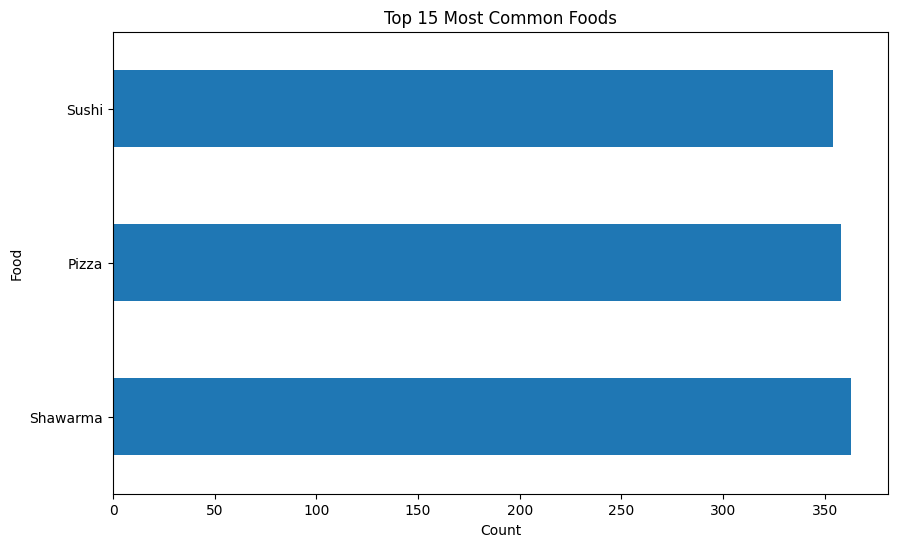


Total samples: 1075
Unique foods: 3

Most common: Shawarma


In [37]:

# Distribution of food types
print("Food distribution:")
print(y_train.value_counts())

# Visualization
plt.figure(figsize=(10, 6))
y_train.value_counts().head(15).plot(kind='barh')
plt.title('Top 15 Most Common Foods')
plt.xlabel('Count')
plt.show()

# Check for class imbalance
print(f"\nTotal samples: {len(y_train)}")
print(f"Unique foods: {y_train.nunique()}")
print(f"\nMost common: {y_train.mode()[0]}")

In [38]:
#TARGET VARIABLE EDA 

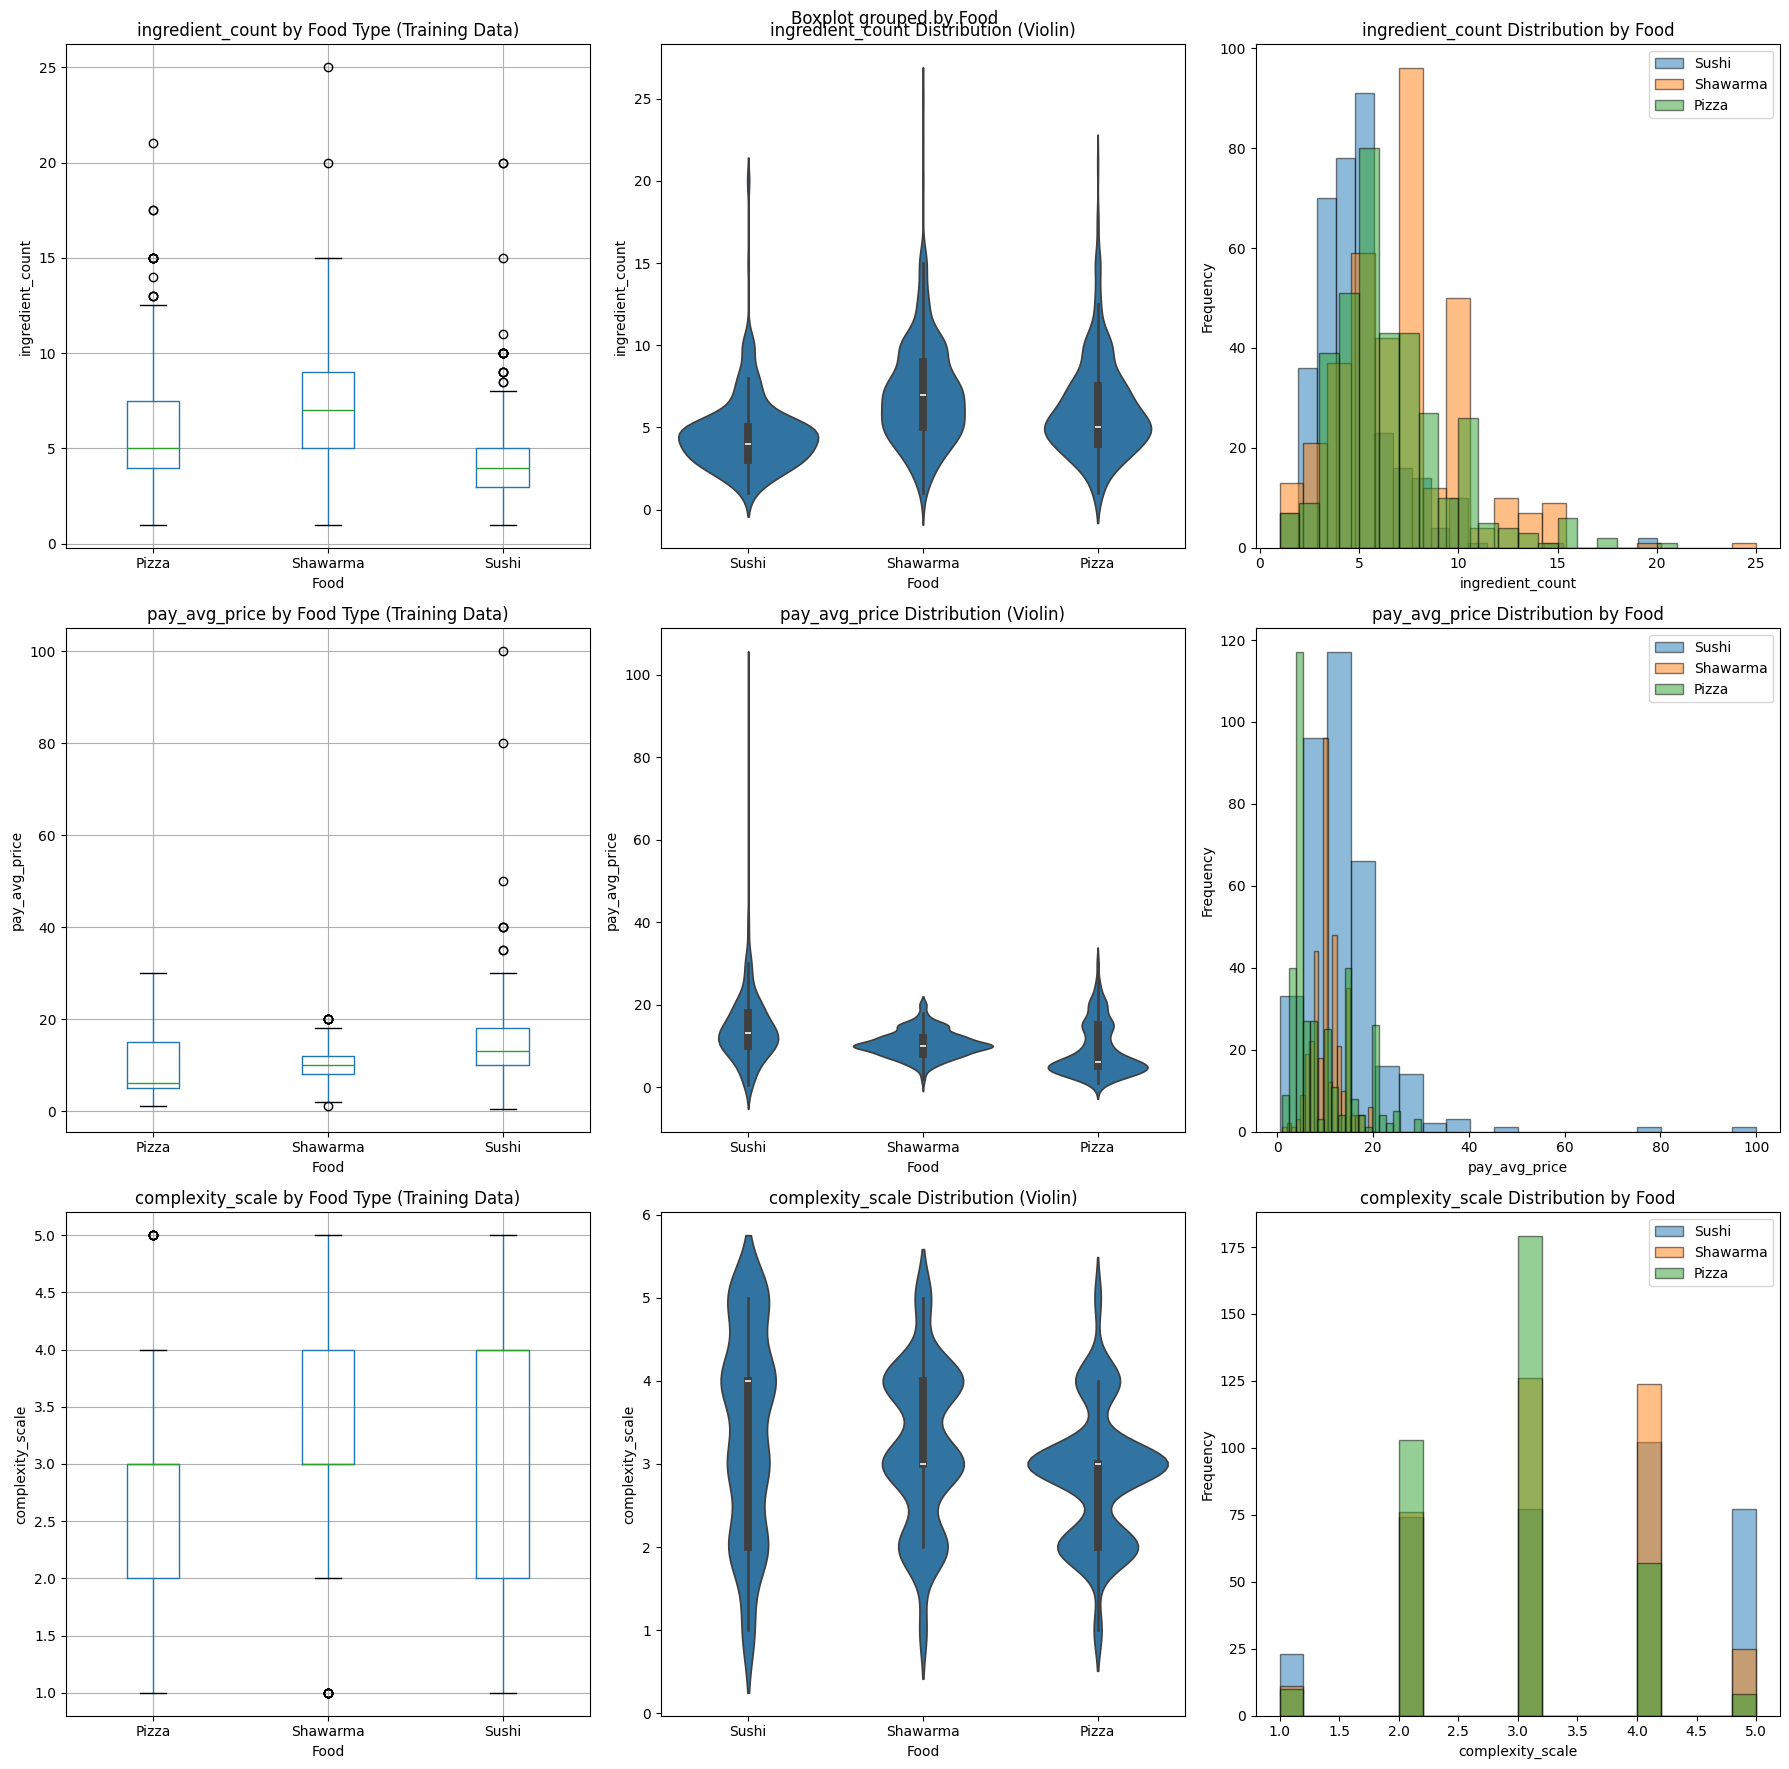

In [ ]:
# Combine X_train and y_train back together
train_df = df.copy()
train_df['Food'] = y_train.values  # Add back the target

# Now do EDA on train_df
numerical_cols = ['ingredient_count', 'pay_avg_price', 'complexity_scale']

n_features = len(numerical_cols)
fig, axes = plt.subplots(n_features, 3, figsize=(18, 6*n_features))

if n_features == 1:
    axes = axes.reshape(1, -1)

for i, feature in enumerate(numerical_cols):
    # Box plot
    train_df.boxplot(column=feature, by='Food', ax=axes[i, 0])
    axes[i, 0].set_title(f'{feature} by Food Type (Training Data)')
    axes[i, 0].set_xlabel('Food')
    axes[i, 0].set_ylabel(feature)
    
    # Violin plot
    sns.violinplot(data=train_df, x='Food', y=feature, ax=axes[i, 1])
    axes[i, 1].set_title(f'{feature} Distribution (Violin)')
    axes[i, 1].set_xlabel('Food')
    
    # Overlapping histograms
    for food in train_df['Food'].unique():
        food_data = train_df[train_df['Food'] == food][feature].dropna()
        axes[i, 2].hist(food_data, bins=20, alpha=0.5, label=food, edgecolor='black')
    axes[i, 2].set_title(f'{feature} Distribution by Food')
    axes[i, 2].set_xlabel(feature)
    axes[i, 2].set_ylabel('Frequency')
    axes[i, 2].legend()

plt.tight_layout()
plt.show()

In [ ]:
# Find the movie one-hot columns
train_df.columns[12:43]

Index(['movie_aladdin', 'movie_anime', 'movie_avengers', 'movie_big hero 6',
       'movie_breaking bad', 'movie_bullet train', 'movie_cars 2',
       'movie_cloudy with a chance of meatballs', 'movie_dictator',
       'movie_fast and furious', 'movie_finding nemo', 'movie_garfield',
       'movie_godfather', 'movie_home alone', 'movie_isle of dogs',
       'movie_japanese', 'movie_jiro dreams of sushi', 'movie_john wick',
       'movie_kill bill', 'movie_kung fu panda', 'movie_madagascar',
       'movie_monsters inc', 'movie_other', 'movie_ratatouille',
       'movie_rush hour', 'movie_spider-man', 'movie_spider-man 2',
       'movie_spirited away', 'movie_teenage mutant ninja turtles',
       'movie_transformers', 'movie_your name'],
      dtype='str')


MOVIE FEATURES BY FOOD TYPE


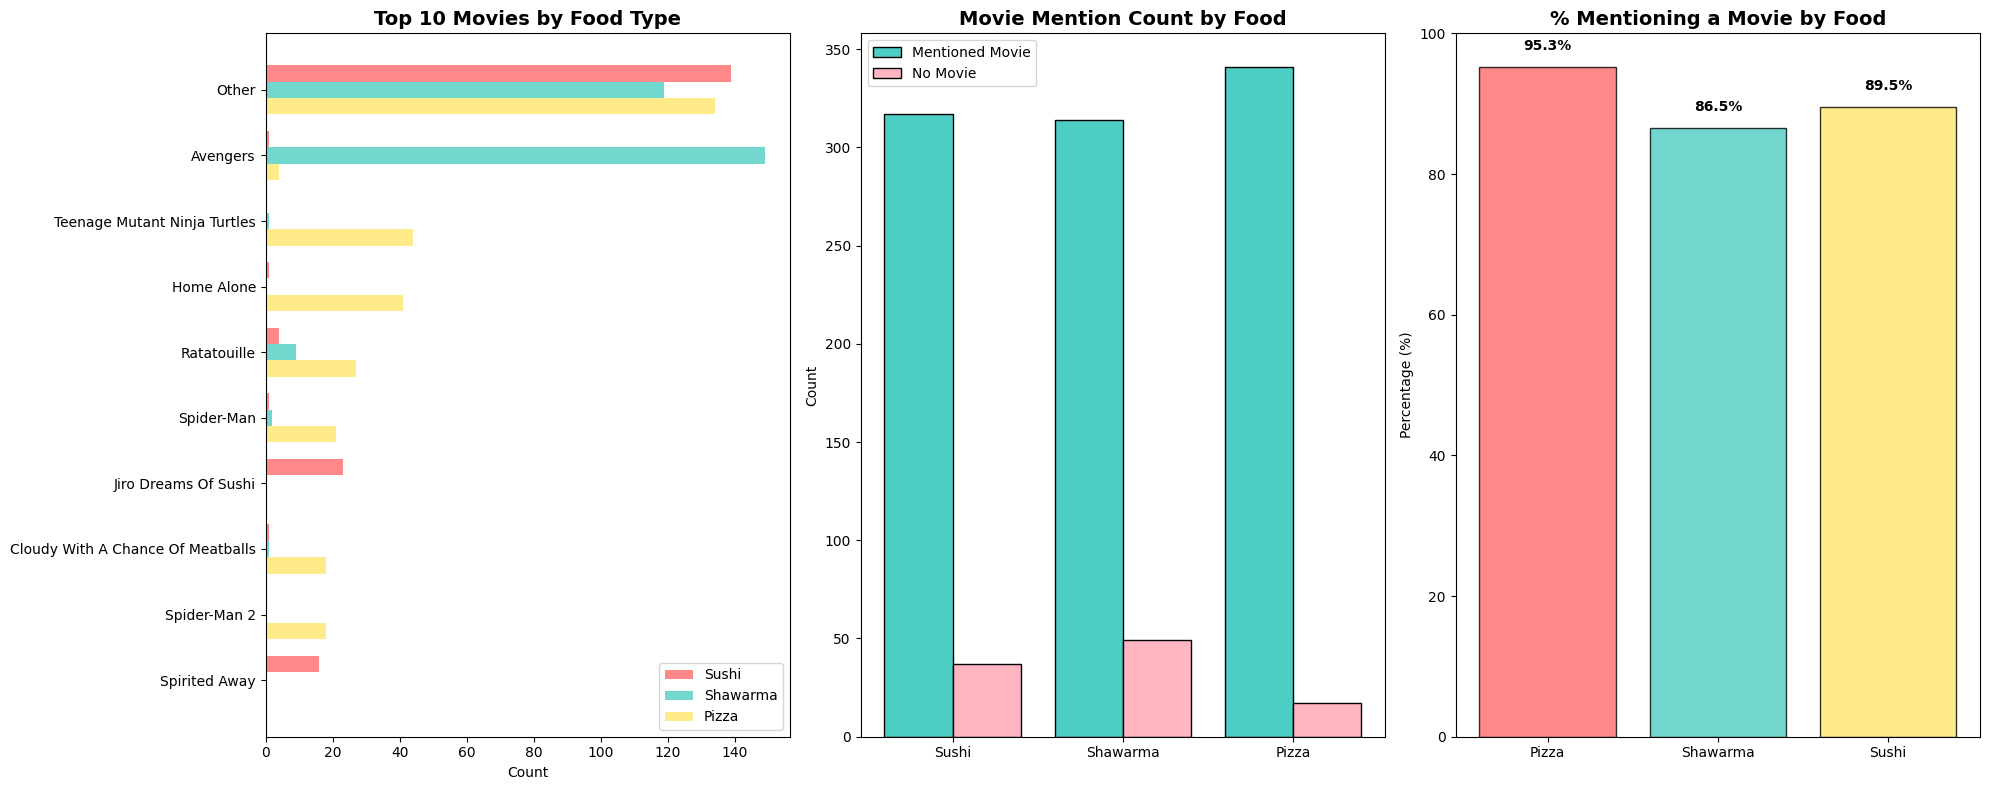


Movie Mention Rate by Food:
Food
Pizza       95.3
Shawarma    86.5
Sushi       89.5
Name: mentioned_movie, dtype: float64

Top 3 Movies per Food Type:

Sushi:
  Other: 139
  Jiro Dreams Of Sushi: 23
  Spirited Away: 16

Shawarma:
  Avengers: 149
  Other: 119
  Dictator: 14

Pizza:
  Other: 134
  Teenage Mutant Ninja Turtles: 44
  Home Alone: 41


In [ ]:


# Get movie columns
movie_cols = train_df.columns[12:43].tolist()

print("\n" + "="*70)
print("MOVIE FEATURES BY FOOD TYPE")
print("="*70)

# Create subplot structure: 1 row, 3 columns (like numerical features)
fig, axes = plt.subplots(1, 3, figsize=(20, 8))

# Plot 1: Top movies per food (side by side bars)
food_types = train_df['Food'].unique()
colours = ['#FF6B6B', '#4ECDC4', '#FFE66D']

# Get top 10 movies overall
top_10_movies = train_df[movie_cols].sum().sort_values(ascending=False).head(10)
movie_names = [m.replace('movie_', '').replace('_', ' ').title() for m in top_10_movies.index]

# Plot grouped bar chart
x = np.arange(len(top_10_movies))
width = 0.25

for i, food in enumerate(food_types):
    food_df = train_df[train_df['Food'] == food]
    counts = [food_df[col].sum() for col in top_10_movies.index]
    axes[0].barh(x + i*width, counts, width, label=food, color=colours[i], alpha=0.8)

axes[0].set_yticks(x + width)
axes[0].set_yticklabels(movie_names)
axes[0].set_xlabel('Count')
axes[0].set_title('Top 10 Movies by Food Type', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].invert_yaxis()

# Plot 2: Movie mention rate by food (like violin plot position)
train_df['mentioned_movie'] = train_df['movie_canonical'].notna().astype(int)

# Count mentioned vs not mentioned for each food
# Not Mentioned is all zeroes
mention_data = []
for food in food_types:
    food_df = train_df[train_df['Food'] == food]
    mention_data.append({
        'Food': food,
        'Mentioned': food_df['mentioned_movie'].sum(),
        'Not Mentioned': len(food_df) - food_df['mentioned_movie'].sum() 
    })

mention_df = pd.DataFrame(mention_data)

x_pos = np.arange(len(food_types))
axes[1].bar(x_pos - 0.2, mention_df['Mentioned'], 0.4, label='Mentioned Movie', 
            color='#4ECDC4', edgecolor='black')
axes[1].bar(x_pos + 0.2, mention_df['Not Mentioned'], 0.4, label='No Movie', 
            color='#FFB6C1', edgecolor='black')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(food_types)
axes[1].set_ylabel('Count')
axes[1].set_title('Movie Mention Count by Food', fontsize=14, fontweight='bold')
axes[1].legend()

# Plot 3: Percentage mentioning movies (like histogram position)
mention_rate = train_df.groupby('Food')['mentioned_movie'].mean() * 100

axes[2].bar(range(len(mention_rate)), mention_rate.values, 
            color=colours, edgecolor='black', alpha=0.8)
axes[2].set_xticks(range(len(mention_rate)))
axes[2].set_xticklabels(mention_rate.index)
axes[2].set_ylabel('Percentage (%)')
axes[2].set_ylim(0, 100)
axes[2].set_title('% Mentioning a Movie by Food', fontsize=14, fontweight='bold')

# Add percentage labels on bars
for i, v in enumerate(mention_rate.values):
    axes[2].text(i, v + 2, f'{v:.1f}%', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Print statistics
print("\nMovie Mention Rate by Food:")
print(mention_rate.round(1))

print("\nTop 3 Movies per Food Type:")
for food in food_types:
    food_df = train_df[train_df['Food'] == food]
    top_3 = food_df[movie_cols].sum().sort_values(ascending=False).head(3)
    print(f"\n{food}:")
    for movie, count in top_3.items():
        movie_name = movie.replace('movie_', '').replace('_', ' ').title()
        print(f"  {movie_name}: {int(count)}")



In [42]:
train_df.columns

Index(['From a scale 1 to 5, how complex is it to make this food? (Where 1 is the most simple, and 5 is the most complex)',
       'How many ingredients would you expect this food item to contain?',
       'In what setting would you expect this food to be served? Please check all that apply',
       'How much would you expect to pay for one serving of this food item?',
       'What movie do you think of when thinking of this food item?',
       'What drink would you pair with this food item?',
       'When you think about this food item, who does it remind you of?',
       'How much hot sauce would you add to this food item?',
       'How many ingredients would you expect this food item to contain? (min)',
       'How many ingredients would you expect this food item to contain? (max)',
       'ingredient_count', 'movie_canonical', 'movie_aladdin', 'movie_anime',
       'movie_avengers', 'movie_big hero 6', 'movie_breaking bad',
       'movie_bullet train', 'movie_cars 2',
       'movie

In [ ]:
hot_sauce_cols = [col for col in train_df.columns if col.startswith('hot_sauce_')]
setting_cols = [col for col in train_df.columns if col.startswith('setting_')]

['setting_At a party',
 'setting_Late night snack',
 'setting_Week day dinner',
 'setting_Week day lunch',
 'setting_Weekend dinner',
 'setting_Weekend lunch']


CATEGORICAL FEATURES BY FOOD TYPE


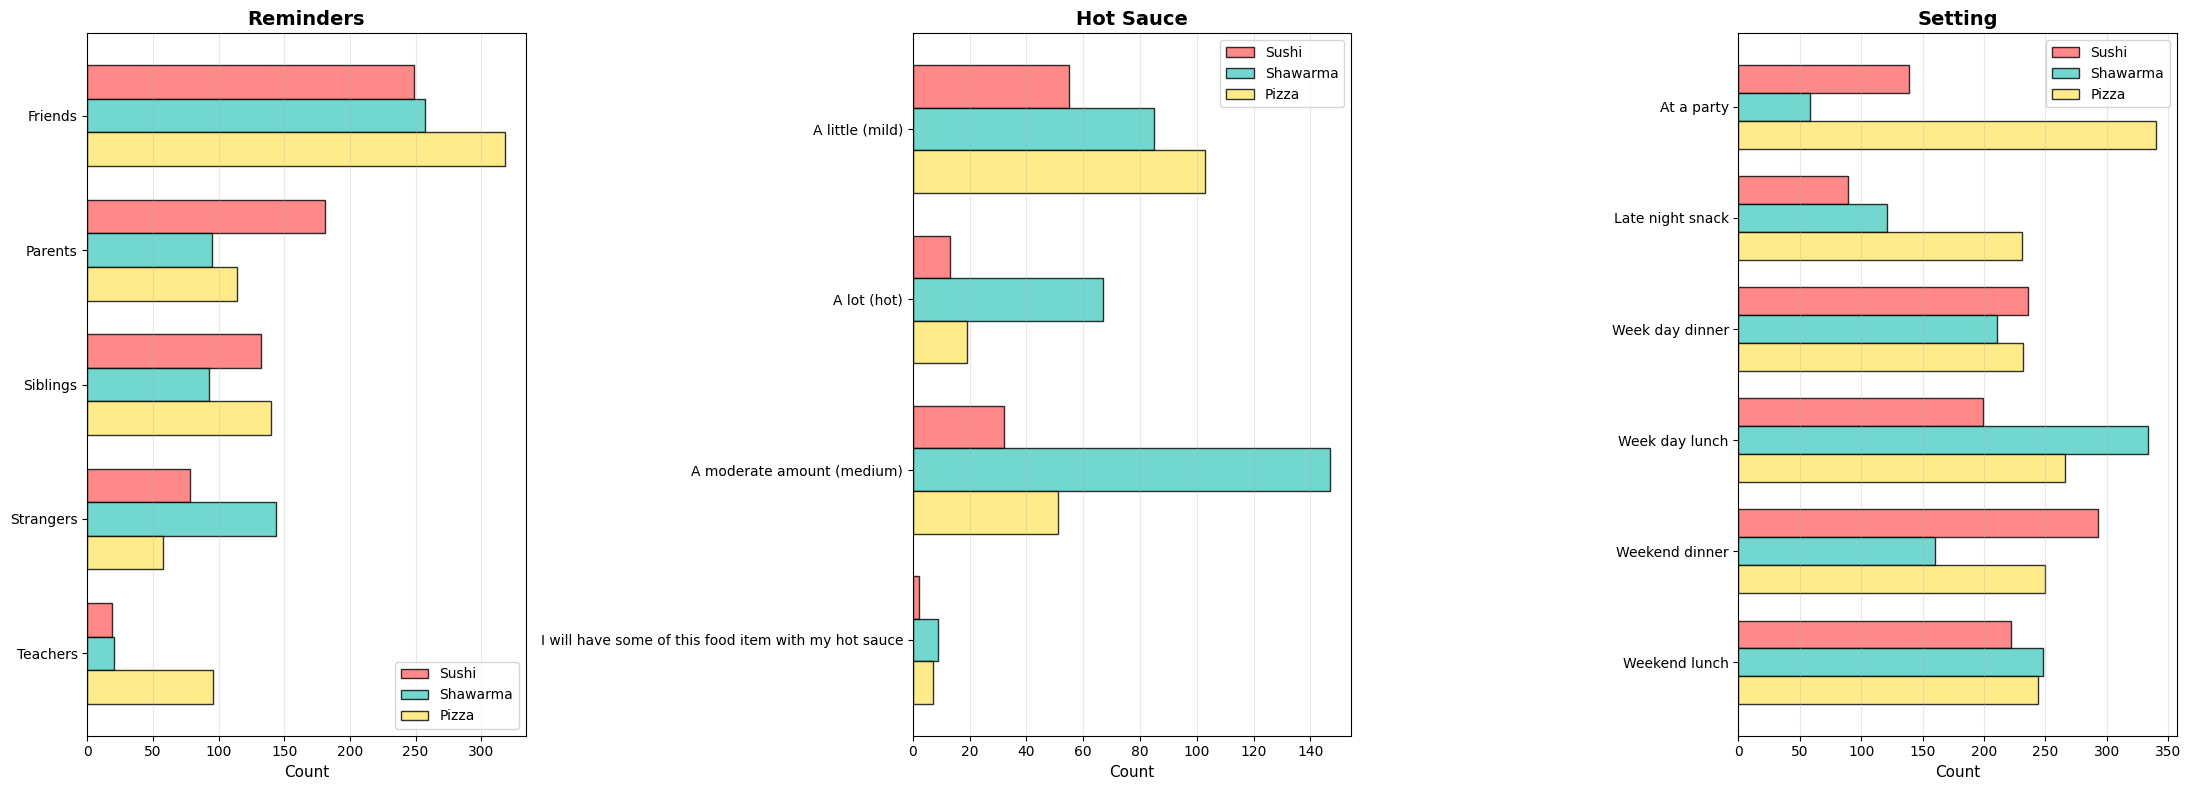


REMINDERS BREAKDOWN BY FOOD TYPE

Sushi:
  Friends: 249 (70.3%)
  Parents: 181 (51.1%)
  Siblings: 132 (37.3%)
  Strangers: 78 (22.0%)
  Teachers: 19 (5.4%)

Shawarma:
  Friends: 257 (70.8%)
  Parents: 95 (26.2%)
  Siblings: 93 (25.6%)
  Strangers: 144 (39.7%)
  Teachers: 20 (5.5%)

Pizza:
  Friends: 318 (88.8%)
  Parents: 114 (31.8%)
  Siblings: 140 (39.1%)
  Strangers: 58 (16.2%)
  Teachers: 96 (26.8%)

HOT SAUCE BREAKDOWN BY FOOD TYPE

Sushi:
  A little (mild): 55 (15.5%)
  A lot (hot): 13 (3.7%)
  A moderate amount (medium): 32 (9.0%)
  I will have some of this food item with my hot sauce: 2 (0.6%)

Shawarma:
  A little (mild): 85 (23.4%)
  A lot (hot): 67 (18.5%)
  A moderate amount (medium): 147 (40.5%)
  I will have some of this food item with my hot sauce: 9 (2.5%)

Pizza:
  A little (mild): 103 (28.8%)
  A lot (hot): 19 (5.3%)
  A moderate amount (medium): 51 (14.2%)
  I will have some of this food item with my hot sauce: 7 (2.0%)

SETTING BREAKDOWN BY FOOD TYPE

Sushi:
  At 

In [68]:
# Get the column groups
remind_cols = [col for col in train_df.columns if col.startswith('remind_')]
hot_sauce_cols = [col for col in train_df.columns if col.startswith('hot_sauce_')]
setting_cols = [col for col in train_df.columns if col.startswith('setting_')]

# Combine all column groups
all_col_groups = [
    ('Reminders', remind_cols),
    ('Hot Sauce', hot_sauce_cols),
    ('Setting', setting_cols)
]

print("\n" + "="*70)
print("CATEGORICAL FEATURES BY FOOD TYPE")
print("="*70)

# Convert all to numeric
for title, cols in all_col_groups:
    for col in cols:
        try:
            if pd.api.types.is_numeric_dtype(train_df[col]):
                train_df[col] = train_df[col].fillna(0).astype(int)
            else:
                train_df[col] = pd.to_numeric(train_df[col], errors='coerce').fillna(0).astype(int)
        except Exception as e:
            print(f"Error converting {col}: {e}")

# Create 3 subplots (1 row, 3 columns)
fig, axes = plt.subplots(1, 3, figsize=(22, 8))

food_types = train_df['Food'].unique()
colours = ['#FF6B6B', '#4ECDC4', '#FFE66D']

# Plot each category
for plot_idx, (title, cols) in enumerate(all_col_groups):
    if not cols:
        axes[plot_idx].text(0.5, 0.5, f'No {title} columns found', 
                           ha='center', va='center', fontsize=12)
        axes[plot_idx].set_title(title, fontsize=14, fontweight='bold')
        continue
    
    # Clean column names for display
    feature_names = [col.replace(f'{title.lower().replace(" ", "_")}_', '')
                    .replace('remind_', '')
                    .replace('hot_sauce_', '')
                    .replace('setting_', '')
                    for col in cols]
    
    x = np.arange(len(cols))
    width = 0.25
    
    # Plot bars for each food type
    for i, food in enumerate(food_types):
        food_df = train_df[train_df['Food'] == food]
        counts = [int(food_df[col].sum()) for col in cols]
        axes[plot_idx].barh(x + i*width, counts, width, label=food, 
                           color=colours[i], alpha=0.8, edgecolor='black')
    
    axes[plot_idx].set_yticks(x + width)
    axes[plot_idx].set_yticklabels(feature_names, fontsize=10)
    axes[plot_idx].set_xlabel('Count', fontsize=11)
    axes[plot_idx].set_title(title, fontsize=14, fontweight='bold')
    axes[plot_idx].legend()
    axes[plot_idx].invert_yaxis()
    axes[plot_idx].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

# Print statistics for all three
for title, cols in all_col_groups:
    if not cols:
        continue
    
    print("\n" + "="*70)
    print(f"{title.upper()} BREAKDOWN BY FOOD TYPE")
    print("="*70)
    
    for food in food_types:
        food_df = train_df[train_df['Food'] == food]
        print(f"\n{food}:")
        for col in cols:
            count = int(food_df[col].sum())
            pct = (count / len(food_df) * 100)
            feature_name = col.replace('remind_', '').replace('hot_sauce_', '').replace('setting_', '')
            print(f"  {feature_name}: {count} ({pct:.1f}%)")

In [ ]:
# hot_sauce = df['How much hot sauce would you add to this food item?'].str.get_dummies(sep=',')
# remind = df['When you think about this food item, who does it remind you of?'].str.get_dummies(sep=',')
# setting 

Features with |r| >= 0.1: 18


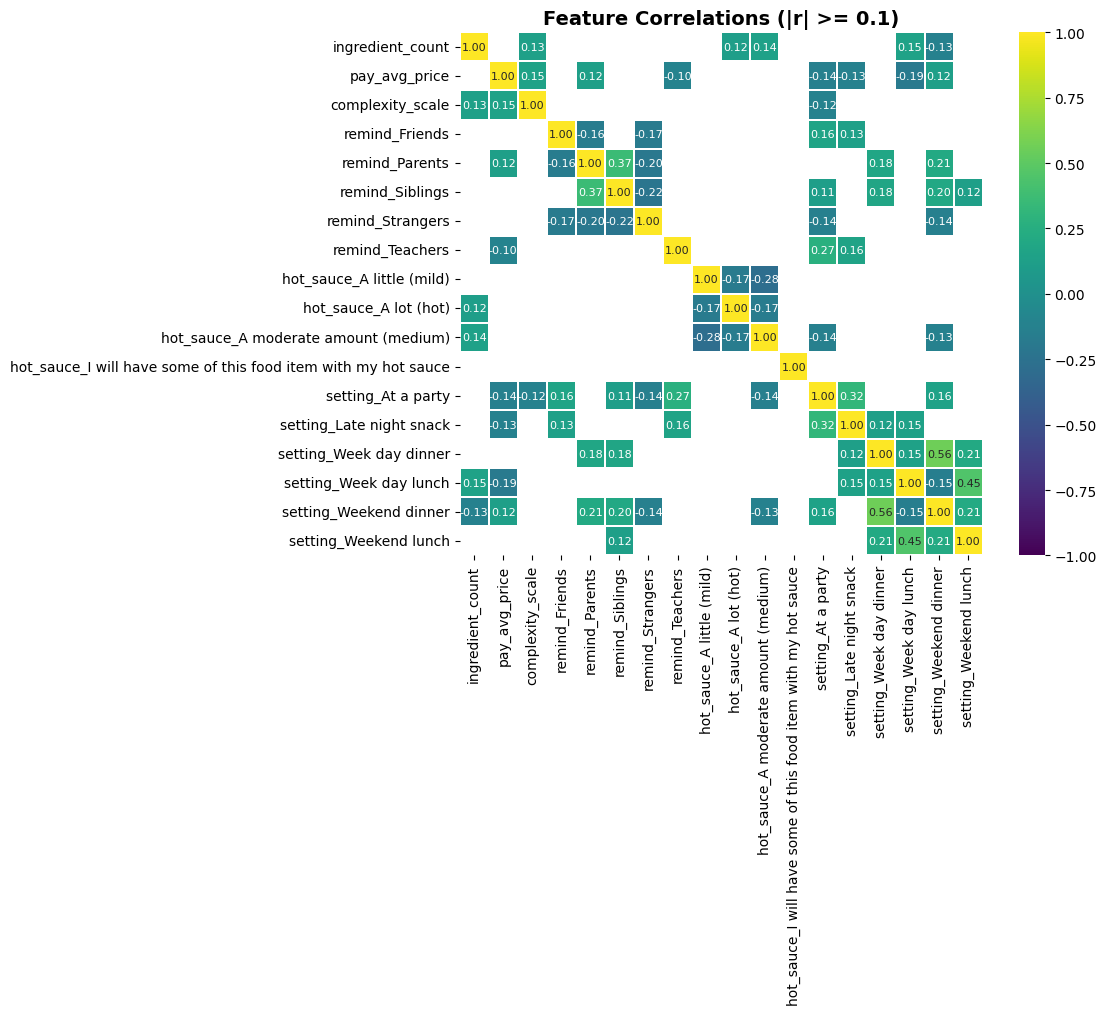

In [ ]:
all_features = numerical_cols + remind_cols + hot_sauce_cols + setting_cols
corr = train_df[all_features].corr()

threshold = 0.1 

filtered_corr = corr[(corr >= threshold) | (corr <= -threshold)]
filtered_corr = filtered_corr.dropna(axis=0, how='all').dropna(axis=1, how='all')

print(f"Features with |r| >= {threshold}: {filtered_corr.shape[0]}")

if filtered_corr.shape[0] > 0:
    plt.figure(figsize=(max(12, filtered_corr.shape[0] * 0.5), 
                        max(10, filtered_corr.shape[1] * 0.5)))
    
    sns.heatmap(filtered_corr, 
                cmap='viridis', 
                vmax=1.0, 
                vmin=-1.0, 
                linewidths=0.1,
                annot=True, 
                annot_kws={"size": 8}, 
                square=True,
                fmt='.2f')
    
    plt.title(f'Feature Correlations (|r| >= {threshold})', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
else:
    print(f"No correlations found with |r| >= {threshold}")
    print("Try an even lower threshold (e.g., 0.2)")

Features with |r| >= 0.1: 49


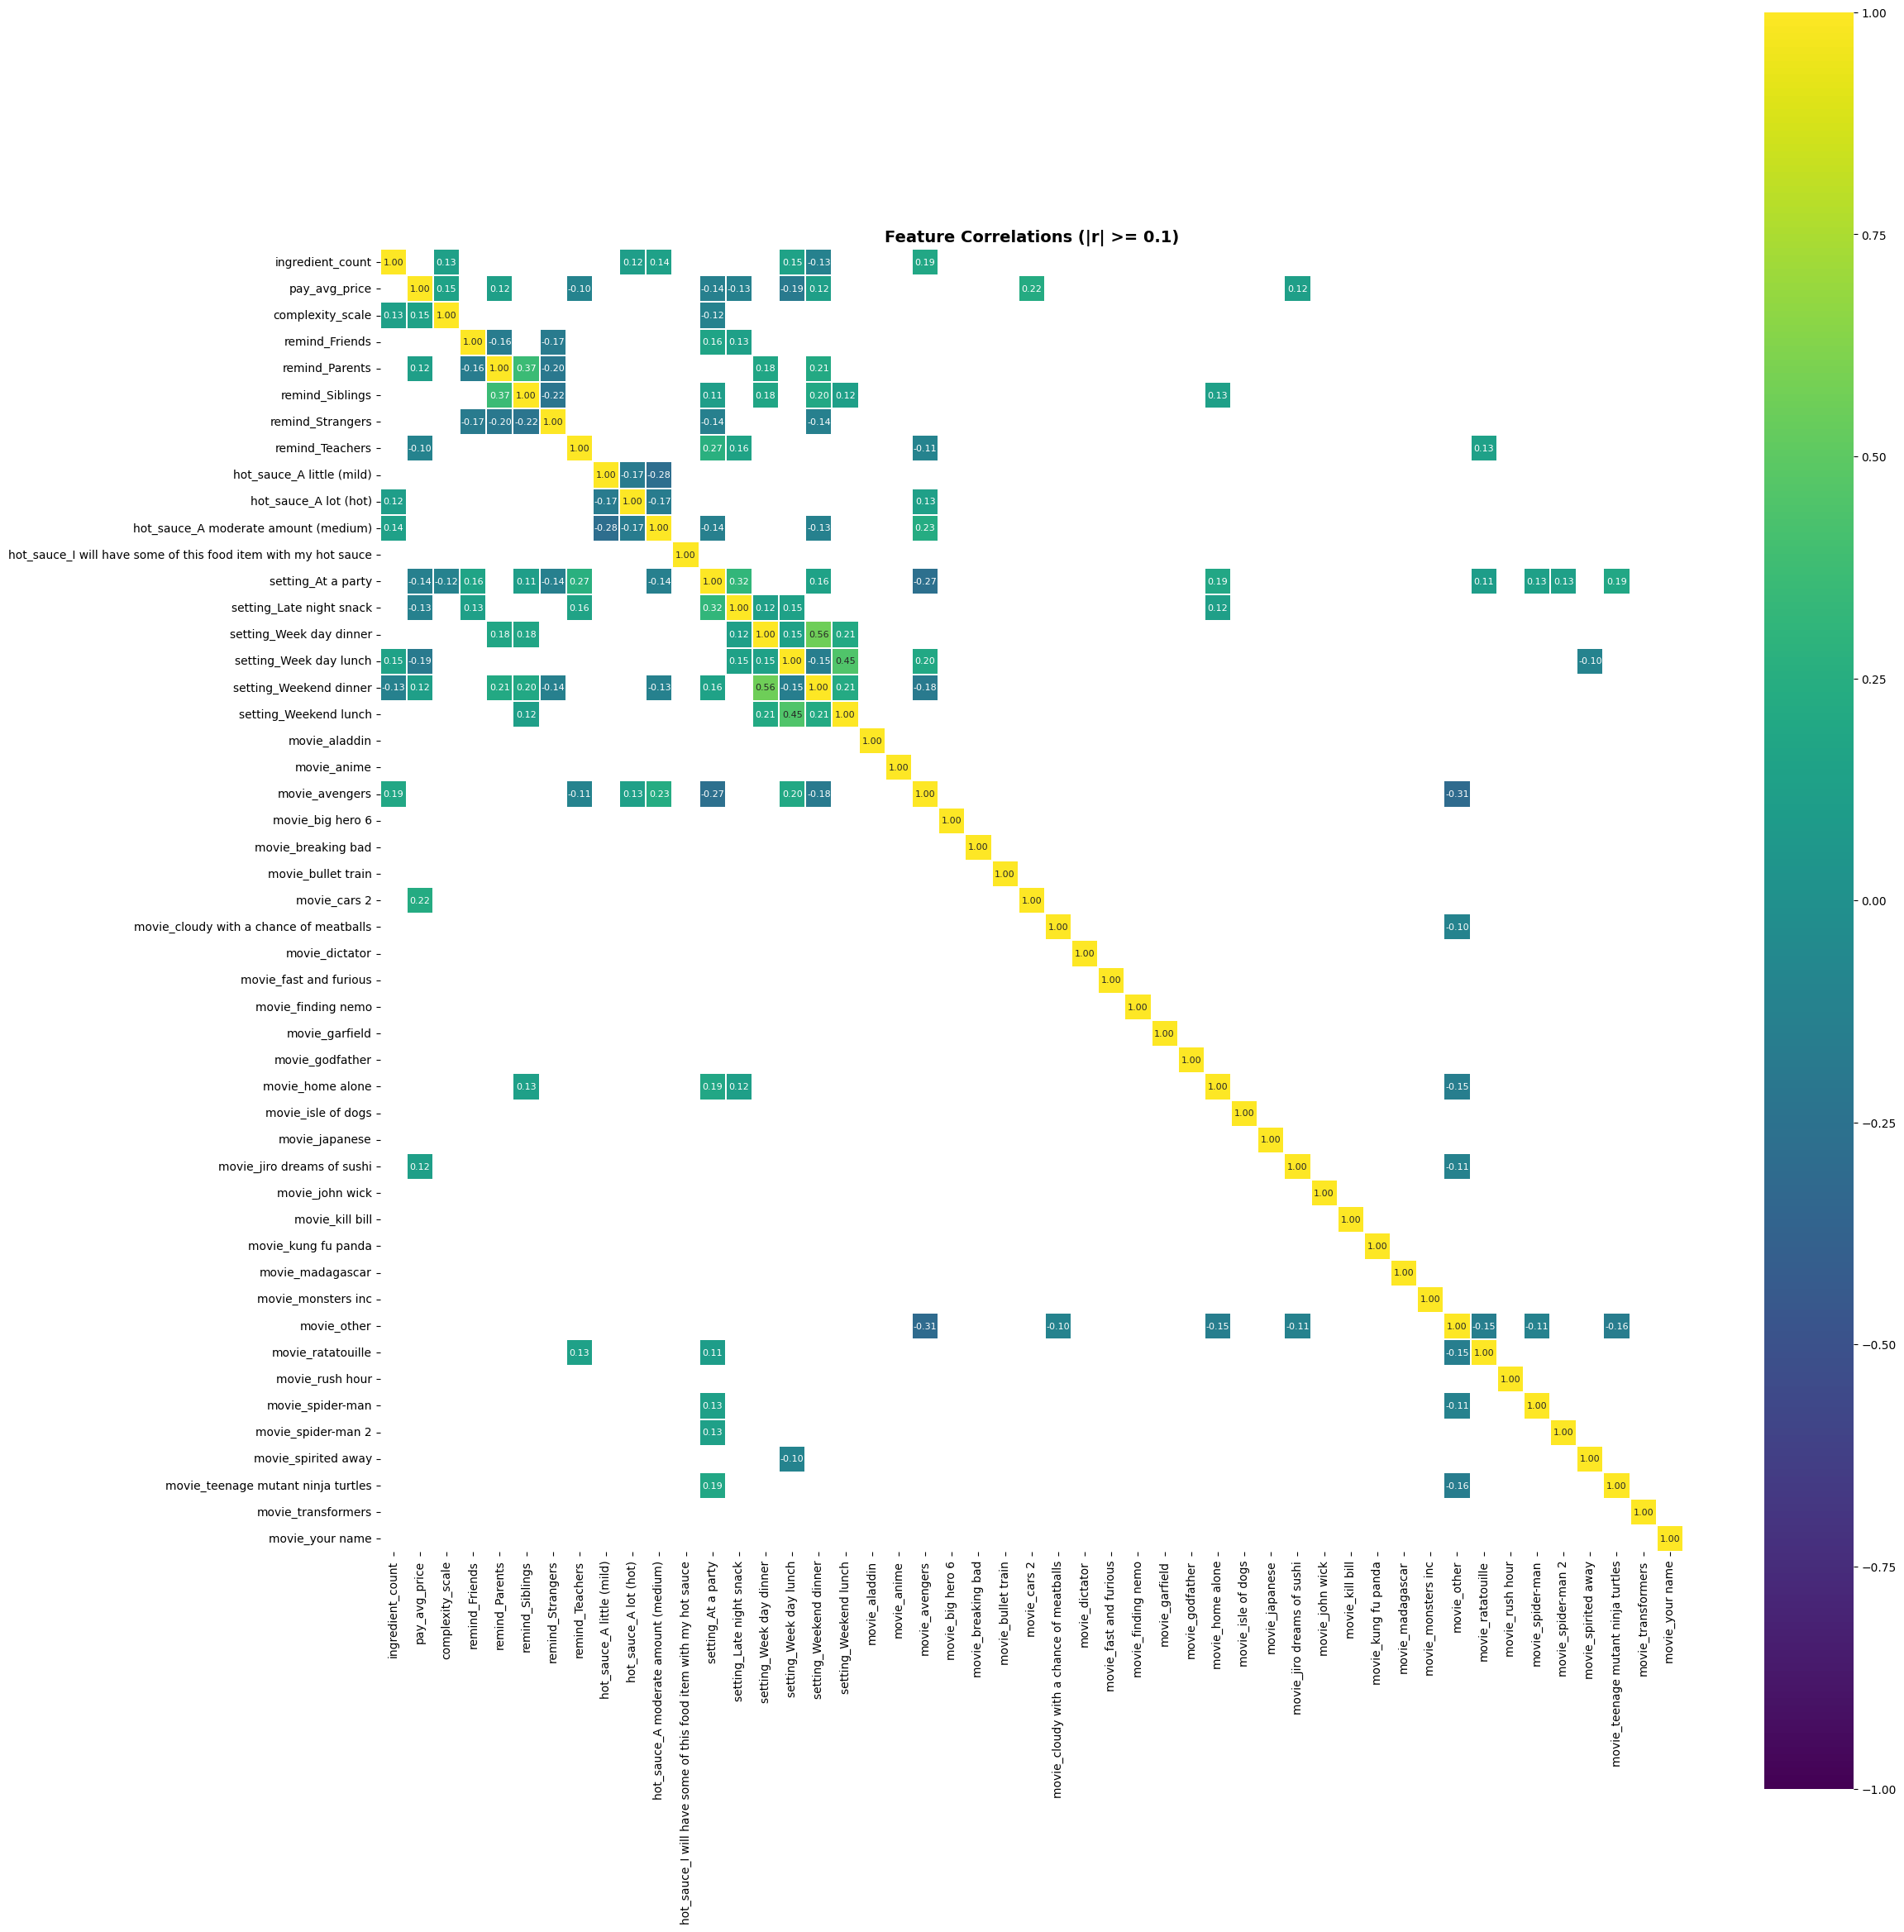

In [66]:


all_features = numerical_cols + remind_cols + hot_sauce_cols + setting_cols + movie_cols
corr = train_df[all_features].corr()

threshold = 0.1 

filtered_corr = corr[(corr >= threshold) | (corr <= -threshold)]
filtered_corr = filtered_corr.dropna(axis=0, how='all').dropna(axis=1, how='all')

print(f"Features with |r| >= {threshold}: {filtered_corr.shape[0]}")

if filtered_corr.shape[0] > 0:
    plt.figure(figsize=(max(12, filtered_corr.shape[0] * 0.5), 
                        max(10, filtered_corr.shape[1] * 0.5)))
    
    sns.heatmap(filtered_corr, 
                cmap='viridis', 
                vmax=1.0, 
                vmin=-1.0, 
                linewidths=0.1,
                annot=True, 
                annot_kws={"size": 8}, 
                square=True,
                fmt='.2f')
    
    plt.title(f'Feature Correlations (|r| >= {threshold})', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
else:
    print(f"No correlations found with |r| >= {threshold}")
    print("Try an even lower threshold (e.g., 0.2)")